# TASK 5

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
%tensorflow_version 2.x
import os
import itertools
import csv
import numpy as np
import tensorflow as tf
import random as rn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import joblib
from sklearn.svm import LinearSVC, SVC
from skimage import exposure
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task5_1') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 64


# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## Utility function

### Loading training and test set

In [8]:
# Loading training and test set
def load_train():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels

### Plotting the confusion matrix

In [9]:
# function to print the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

### Plotting the ROC curve

In [10]:
def plot_roc_curve(model, test_im, test_labels):
    probs = model.predict(test_im)
    fpr, tpr, threshold = roc_curve(test_labels, probs)
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Plotting accuracy and loss trends

In [11]:
def performance_plot(history, model):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig1 = plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Setting the seed

In [12]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

## Dataset creation

In [13]:
train_img, train_lab = load_train()
test_img, test_lab = load_test()


In [14]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') / 65535

# mass
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 2] = 0
# calcification
abnormality_labels[abnormality_labels == 3] = 1
abnormality_labels[abnormality_labels == 4] = 1

# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.30, random_state=42, stratify=abnormality_labels)

# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') / 65535

# mass
test_labels[test_labels == 1] = 0
test_labels[test_labels == 2] = 0
# calcification
test_labels[test_labels == 3] = 1
test_labels[test_labels == 4] = 1


## Loading the best models

In [15]:
model1 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_1/model10_best.h5'))
#result = model1.evaluate(test_images, test_labels, batch_size=64)
#print(result)

model2 = models.load_model(os.path.join(DIR_PATH, 'models/models_task2_1/model9_best.h5'))
#result = model2.evaluate(test_images, test_labels, batch_size=64)
#print(result)


## Ensemble with models from scratch

### Logistic Regression

Stacked Train Accuracy: 0.907
Stacked Test Accuracy: 0.872
Specificity :  0.88268156424581
Sensitivity :  0.8598726114649682


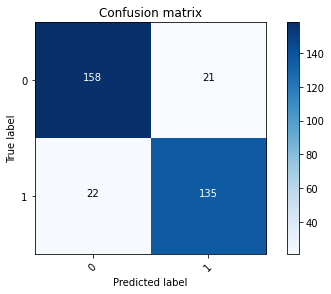

Stacked Valid Accuracy: 0.903
Specificity :  0.8931506849315068
Sensitivity :  0.910958904109589


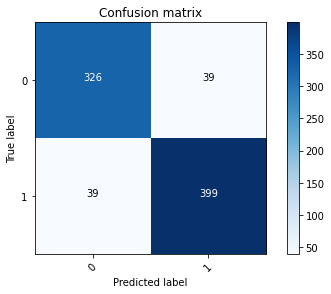

In [ ]:
# create stacked model input dataset as outputs from the ensemble
set_seed()

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[model1,model2]

# fit stacked model using the ensemble
ensemble = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble, os.path.join(MODEL_PATH, 'logreg.h5'))

train_pred = stacked_prediction(members, ensemble, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model on test set
test_pred = stacked_prediction(members, ensemble, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### LinearSVC

Stacked Train Accuracy: 0.904
Stacked Test Accuracy: 0.872
Specificity :  0.8994413407821229
Sensitivity :  0.8407643312101911


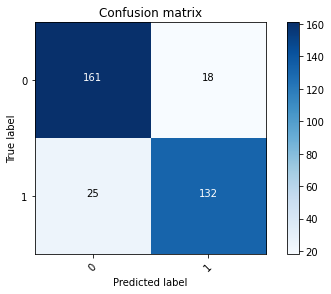

Stacked Valid Accuracy: 0.903
Specificity :  0.9013698630136986
Sensitivity :  0.9041095890410958


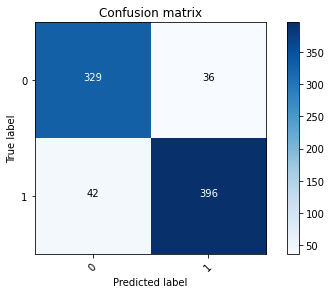

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model.predict(inputX)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble2 members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LinearSVC()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[model1,model2]

# fit stacked model using the ensemble
ensemble2 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble2, os.path.join(MODEL_PATH, 'lsvc.h5'))

train_pred = stacked_prediction(members, ensemble2, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model on test set
test_pred = stacked_prediction(members, ensemble2, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble2, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### SVC

Stacked Train Accuracy: 0.907
Stacked Test Accuracy: 0.872
Specificity :  0.88268156424581
Sensitivity :  0.8598726114649682


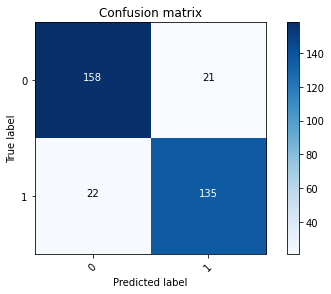

Stacked Valid Accuracy: 0.903
Specificity :  0.8931506849315068
Sensitivity :  0.910958904109589


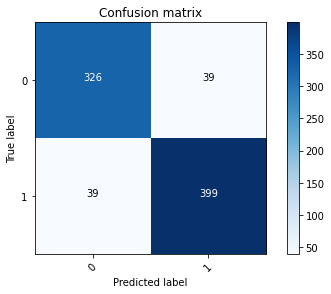

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		pred = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = pred
		else:
			stackX = dstack((stackX, pred))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = SVC()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[model1,model2]

# fit stacked model using the ensemble
ensemble3 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble3, os.path.join(MODEL_PATH, 'svc.h5'))

train_pred = stacked_prediction(members, ensemble3, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate model on test set
test_pred = stacked_prediction(members, ensemble3, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble3, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

## Ensemble with intermediate layers of model from scratch 

In [17]:
intermediate_layer_model1 = keras.Model(inputs=model1.input,
                                       outputs=model1.get_layer("dense_1").output)
intermediate_layer_model2 = keras.Model(inputs=model2.input,
                                       outputs=model2.get_layer("dense").output)

intermediate_layer_model1.save(os.path.join(MODEL_PATH, 'model10_layers.h5'))
intermediate_layer_model2.save(os.path.join(MODEL_PATH, 'model9_layers.h5'))


### Dense layer

Epoch 1/50
59/59 [==============================] - 1s 8ms/step - loss: 0.3689 - acc: 0.8814 - val_loss: 0.2572 - val_acc: 0.8966

Epoch 00001: val_loss improved from inf to 0.25720, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model1_best.h5
Epoch 2/50
59/59 [==============================] - 0s 3ms/step - loss: 0.2412 - acc: 0.9105 - val_loss: 0.2509 - val_acc: 0.9004

Epoch 00002: val_loss improved from 0.25720 to 0.25087, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model1_best.h5
Epoch 3/50
59/59 [==============================] - 0s 2ms/step - loss: 0.2575 - acc: 0.8952 - val_loss: 0.2472 - val_acc: 0.9004

Epoch 00003: val_loss improved from 0.25087 to 0.24722, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model1_best.h5
Epoch 4/50
59/59 [==============================] - 0s 2ms/step - loss: 0.2529 - acc: 0.9020 - val_loss: 0.2459 - val_acc: 0.

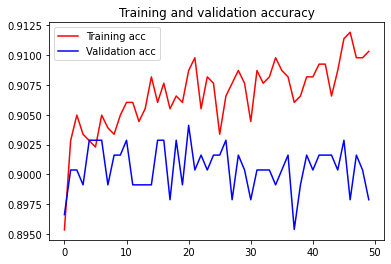

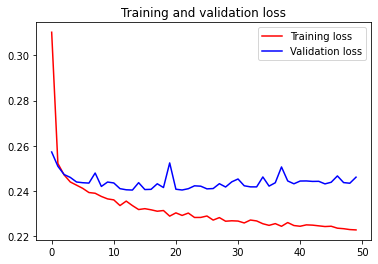

Stacked Train Accuracy: 0.907
Stacked Test Accuracy: 0.869
Specificity :  0.8938547486033519
Sensitivity :  0.8407643312101911


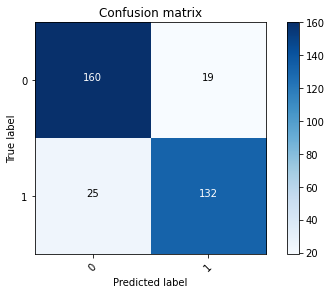

Stacked Valid Accuracy: 0.899
Specificity :  0.8986301369863013
Sensitivity :  0.8995433789954338


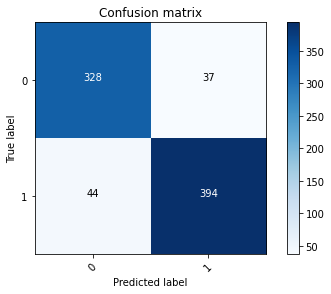

In [18]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, valid_images, valid_labels):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    stacked_valid = stacked_dataset(members, valid_images)
    # fit standalone model
    model = models.Sequential()
    model.add(layers.Dense(1, input_dim=256, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'model1_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(stackedX, inputy, epochs=50, validation_data=(stacked_valid, valid_labels), callbacks = [callback, model_checkpoint])

    performance_plot(history, model)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
model1 = fit_stacked_model(members, train_images, train_labels, valid_images, valid_labels)

model1.save(os.path.join(MODEL_PATH, 'model1.h5'))
best_model = models.load_model(os.path.join(MODEL_PATH, 'model1_best.h5'))

train_pred = stacked_prediction(members, best_model, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model1 on test set
test_pred = stacked_prediction(members, best_model, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, best_model, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### Dense layer and dropout

Epoch 1/100
59/59 [==============================] - 1s 5ms/step - loss: 0.4063 - acc: 0.8298 - val_loss: 0.2588 - val_acc: 0.8979

Epoch 00001: val_loss improved from inf to 0.25884, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model2_best.h5
Epoch 2/100
59/59 [==============================] - 0s 2ms/step - loss: 0.2513 - acc: 0.9040 - val_loss: 0.2508 - val_acc: 0.8979

Epoch 00002: val_loss improved from 0.25884 to 0.25075, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model2_best.h5
Epoch 3/100
59/59 [==============================] - 0s 2ms/step - loss: 0.2689 - acc: 0.8841 - val_loss: 0.2483 - val_acc: 0.8966

Epoch 00003: val_loss improved from 0.25075 to 0.24834, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models/models_task5_1/model2_best.h5
Epoch 4/100
59/59 [==============================] - 0s 2ms/step - loss: 0.2631 - acc: 0.9004 - val_loss: 0.2462 - val_acc

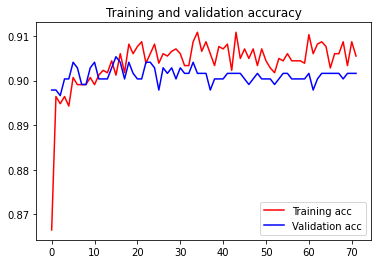

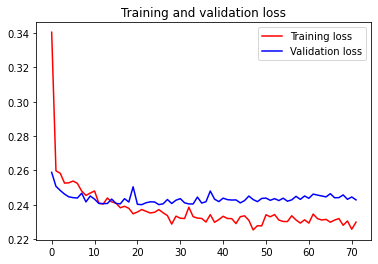

Stacked Train Accuracy: 0.905
Stacked Test Accuracy: 0.869
Specificity :  0.888268156424581
Sensitivity :  0.8471337579617835


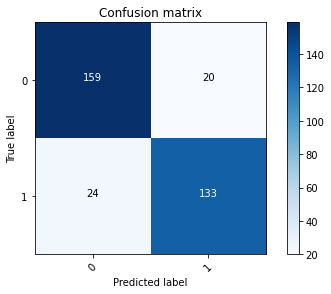

Stacked Valid Accuracy: 0.900
Specificity :  0.8986301369863013
Sensitivity :  0.9018264840182648


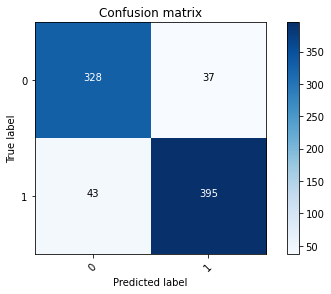

In [20]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy, valid_images, valid_labels):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    stacked_valid = stacked_dataset(members, valid_images)
    # fit standalone model
    model = models.Sequential()
    model.add(layers.Dropout(0.3))
    #model.add(layers.Dense(64, input_dim=256, activation='relu'))
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, input_dim=256, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'model2_best.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True) #, save_weights_only=True)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50)
    history = model.fit(stackedX, inputy, epochs=100, validation_data=(stacked_valid, valid_labels), callbacks = [callback, model_checkpoint])

    performance_plot(history, model)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
model2 = fit_stacked_model(members, train_images, train_labels, valid_images, valid_labels)

model2.save(os.path.join(MODEL_PATH, 'model2.h5'))
best_model2 = models.load_model(os.path.join(MODEL_PATH, 'model2_best.h5'))

train_pred = stacked_prediction(members, best_model2, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate model2 on test set
test_pred = stacked_prediction(members, best_model2, test_images)
test_acc = accuracy_score(test_labels, np.rint(test_pred))
print('Stacked Test Accuracy: %.3f' % test_acc)

cm = confusion_matrix(test_labels, np.rint(test_pred))
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, best_model2, valid_images)
valid_acc = accuracy_score(valid_labels, np.rint(valid_pred))
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, np.rint(valid_pred))
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### Logistic Regression

Stacked Train Accuracy: 0.916
Stacked Test Accuracy: 0.875
Specificity :  0.8770949720670391
Sensitivity :  0.8726114649681529


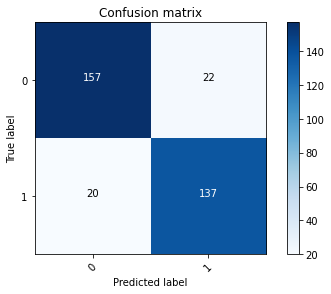

Stacked Valid Accuracy: 0.900
Specificity :  0.8849315068493151
Sensitivity :  0.91324200913242


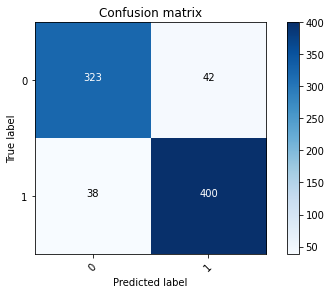

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LogisticRegression(max_iter=500)
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
ensemble4 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble4, os.path.join(MODEL_PATH, 'logreg_layers.h5'))

train_pred = stacked_prediction(members, ensemble4, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate ensemble4 on test set
test_pred = stacked_prediction(members, ensemble4, test_images)
acc = accuracy_score(test_labels, test_pred)
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble4, valid_images)
valid_acc = accuracy_score(valid_labels, valid_pred)
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, valid_pred)
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### LinearSVC

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Stacked Train Accuracy: 0.927
Stacked Test Accuracy: 0.872
Specificity :  0.888268156424581
Sensitivity :  0.8535031847133758


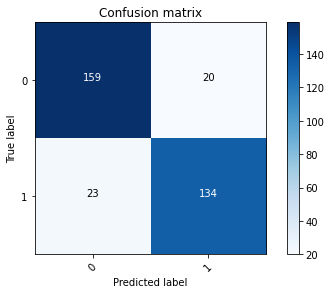

Stacked Valid Accuracy: 0.898
Specificity :  0.8876712328767123
Sensitivity :  0.906392694063927


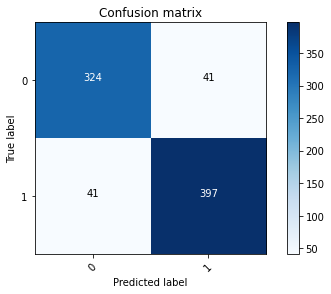

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = LinearSVC()
	model.fit(stackedX, inputy)
	return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	pred = model.predict(stackedX)
	return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
ensemble5 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble5, os.path.join(MODEL_PATH, 'lsvc_layers.h5'))

train_pred = stacked_prediction(members, ensemble5, train_images)
train_acc = accuracy_score(train_labels, np.rint(train_pred))
print('Stacked Train Accuracy: %.3f' % train_acc)

# evaluate ensemble5 on test set
test_pred = stacked_prediction(members, ensemble5, test_images)
acc = accuracy_score(test_labels, test_pred)
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble5, valid_images)
valid_acc = accuracy_score(valid_labels, valid_pred)
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, valid_pred)
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')

### SVC

Stacked Train Accuracy: 0.908
Stacked Test Accuracy: 0.878
Specificity :  0.888268156424581
Sensitivity :  0.8662420382165605


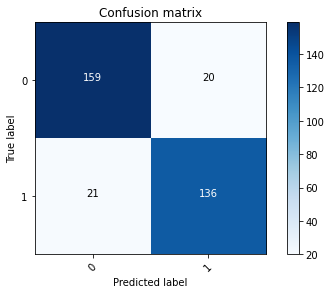

Stacked Valid Accuracy: 0.900
Specificity :  0.8876712328767123
Sensitivity :  0.910958904109589


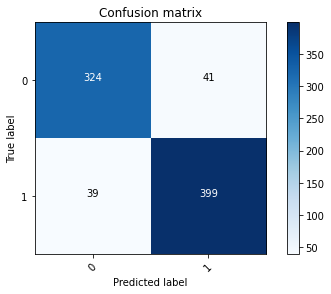

In [ ]:
set_seed()

def stacked_dataset(members, inputX):
    stackX = None
    for model in members:
      # make prediction
      pred = model.predict(inputX, verbose=0)
      if pred.shape[1] == 64:
        pred = np.hstack((pred, pred))
      # stack predictions into [rows, members, probabilities]
      if stackX is None:
        stackX = pred
      else:
        stackX = dstack((stackX, pred))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # fit standalone model
    model = SVC()
    model.fit(stackedX, inputy)
    return model

# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # make a prediction
    pred = model.predict(stackedX)
    return pred

members=[intermediate_layer_model1, intermediate_layer_model2]

# fit stacked model using the ensemble
ensemble6 = fit_stacked_model(members, train_images, train_labels)

joblib.dump(ensemble6, os.path.join(MODEL_PATH, 'svc_layers.h5'))

train_pred = stacked_prediction(members, ensemble6, train_images)
train_acc = accuracy_score(train_labels, train_pred)
print('Stacked Train Accuracy: %.3f' % train_acc)
# evaluate ensemble6 on test set
test_pred = stacked_prediction(members, ensemble6, test_images)
acc = accuracy_score(test_labels, test_pred)
print('Stacked Test Accuracy: %.3f' % acc)

cm = confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')

valid_pred = stacked_prediction(members, ensemble6, valid_images)
valid_acc = accuracy_score(valid_labels, valid_pred)
print('Stacked Valid Accuracy: %.3f' % valid_acc)

cm_valid = confusion_matrix(valid_labels, valid_pred)
plot_confusion_matrix(cm_valid, classes=[0,1], normalize=False, title='Confusion matrix')